In [3]:
from luxai_s2.env import LuxAI_S2
import matplotlib.pyplot as plt
import numpy as np

In [4]:
env = LuxAI_S2() # create the environment object
obs, _ = env.reset(seed=41) # resets an environment with a seed

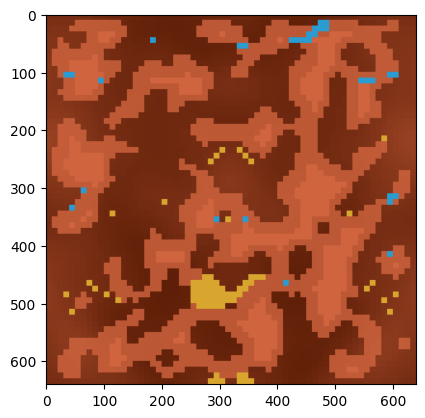

In [5]:
img = env.render("rgb_array", width=640, height=640)
plt.imshow(img)

In [6]:
from lux.kit import obs_to_game_state, GameState, EnvConfig
from luxai_s2.utils import animate
from lux.utils import direction_to, my_turn_to_place_factory
import torch

In [8]:
def animate(imgs, _return=True):
    # using cv2 to generate videos as moviepy doesn't work on kaggle notebooks
    import cv2
    import os
    import string
    import random
    video_name = ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)
def interact(env, agents, steps):
    # reset our env
    obs, _ = env.reset()
    np.random.seed(0)
    imgs = []
    step = 0
    # Note that as the environment has two phases, we also keep track a value called 
    # `real_env_steps` in the environment state. The first phase ends once `real_env_steps` is 0 and used below

    # iterate until phase 1 ends
    while env.state.real_env_steps < 0:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].early_setup(step, o)
            actions[player] = a
        step += 1
        obs, rewards, terminations, truncations, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=640, height=640)]
#         print(termination)
        dones = {k: terminations[k] or truncations[k] for k in terminations}
    done = False
    while not done:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].act(step, o)
            actions[player] = a
        step += 1
        obs, rewards, terminations, truncations, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=640, height=640)]
        dones = {k: terminations[k] or truncations[k] for k in terminations}
        done = dones["player_0"] and dones["player_1"]
    return animate(imgs)

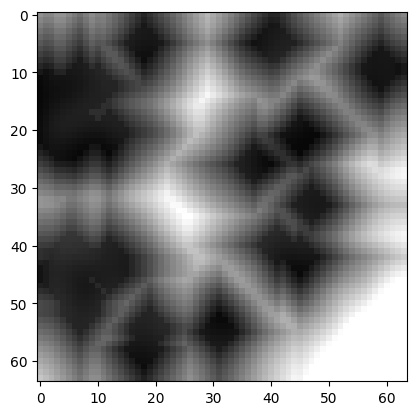

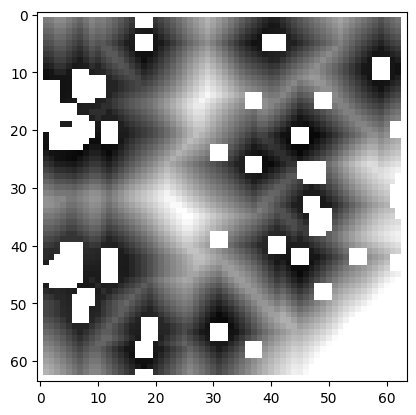

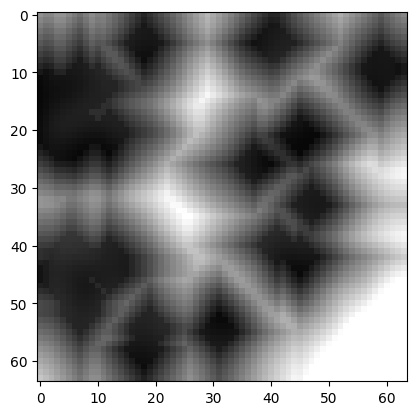

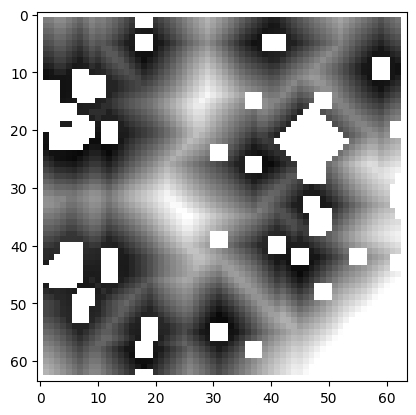

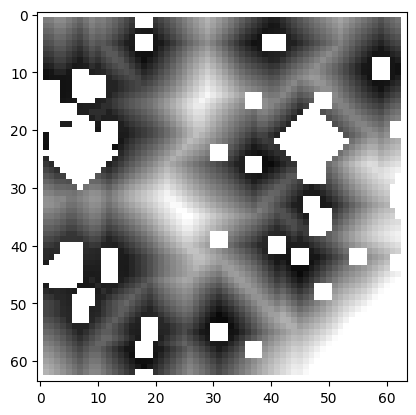

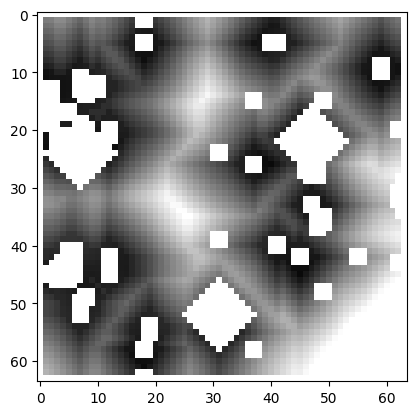

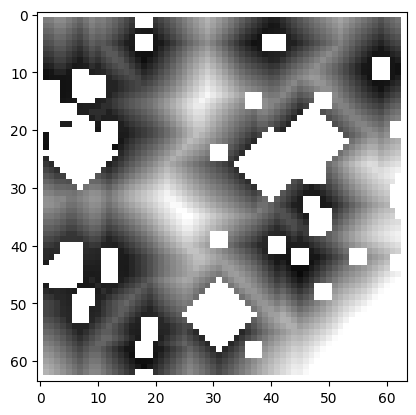

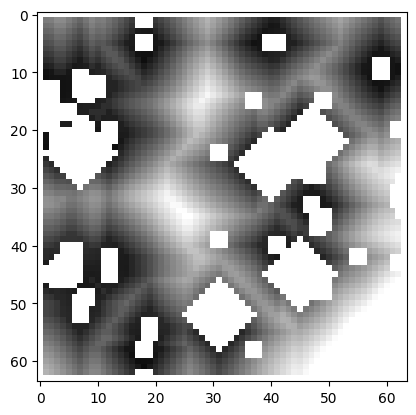

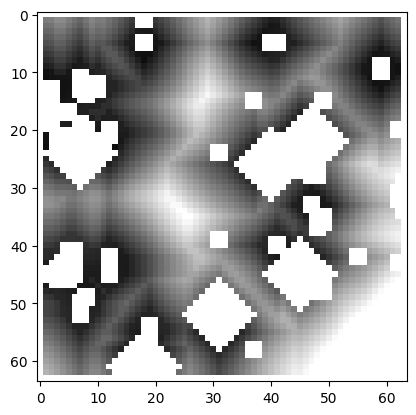

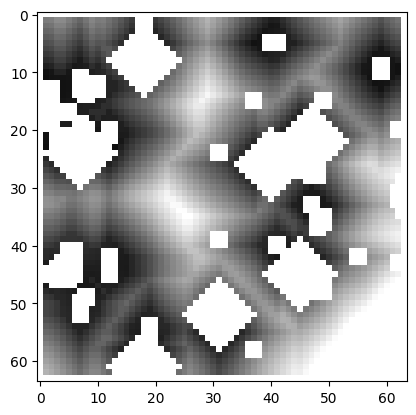

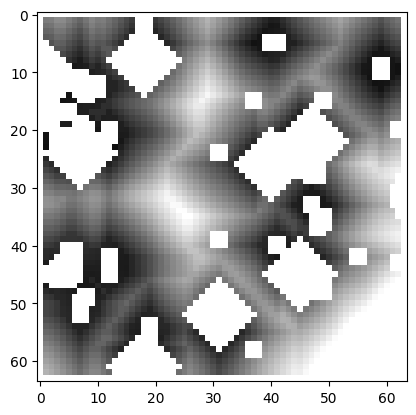

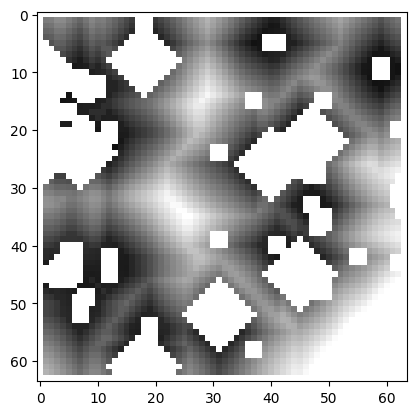

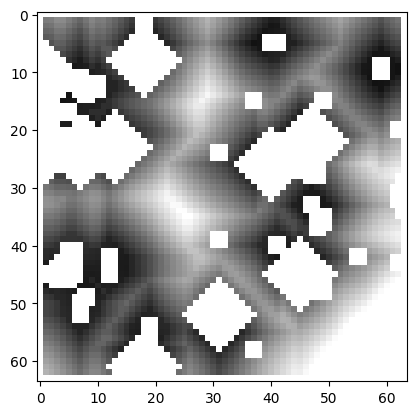

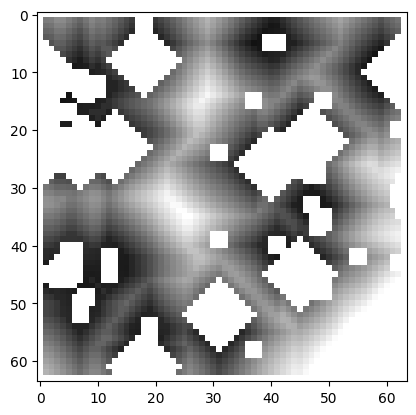

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


In [46]:
# recreate our agents and run
import sys

from importlib import reload
import agent
reload(agent)
Agent = agent.Agent

agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 15)

## CLI Tool

To test your agent without using the python API you can also run

In [12]:
!rm *.webm *.mp4 
!rm -r __pycache__
!rm -r lux/__pycache__


zsh:1: no matches found: *.mp4


In [18]:
!luxai-s2 main.py main.py -v 2 -s 101 -o replay.html

290: player_0 lost all factories
2.6782898902893066


In [19]:
import IPython # load the HTML replay
IPython.display.HTML(filename='replay.html')

which uses a seed of 101 and generates a replay.html file that you can click and watch. Optionally if you specify `-o replay.json` you can upload replay.json to http://s2vis.lux-ai.org/. We **highly recommend** watching on a separate window instead of watching here on a notebook as the notebook screen width is quite small.

The CLI tool enables you to easily run episodes between any two agents (python or not) and provides a flexible tournament running tool to evaluate many agents together. Documentation on this tool can be found here: https://github.com/Lux-AI-Challenge/Lux-Design-S2/tree/main/luxai_runner/README.md

In [39]:
!tar -cvzf * submission.tar.gz

agent.py
lux/
lux/__init__.py
lux/forward_sim.py
lux/config.py
lux/unit.py
lux/factory.py
lux/cargo.py
lux/team.py
lux/utils.py
lux/kit.py
main.py
replay.html
submission.tar.gz
tutorial.ipynb
submission.tar.gz
